# Multi-Resolution Dynamic Mode Decomposition with Control

Importazione delle librerie necessarie.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import math

from pydmd.dmdbase import DMDBase
from pydmd.dmdoperator import DMDOperator
from pydmd.snapshots import Snapshots
from pydmd.utils import compute_svd, compute_tlsq


import scipy.io

Selezione del dataset da utilizzare.

In [2]:
## Parametri per dataset real_eig_timeseries.mat e complex_eig_timeseries.mat
#x = np.linspace(0, 10, 10)
#t = np.linspace(0, 1600, 1600) 

## Parametri per dataset XU_DMDc.mat
x = np.linspace(0, 40, 40)
t = np.linspace(0, 7160, 7160) 

## Scelta del dataset, se a valori complessi o reali
#D_mat = scipy.io.loadmat('real_eig_timeseries.mat')
#D_mat = scipy.io.loadmat('complex_eig_timeseries.mat')
D_mat = scipy.io.loadmat('XU_DMDc.mat')

## Trasformo il formato .mat in un Numpy Array
## Usare in caso di Dataset real/complex_eig_timeseries.mat
#D_mat_list = [[element for element in upperElement] for upperElement in D_mat['xt']]
#D = np.array(D_mat_list)

## Usare in caso di Dataset XU_DMDc.mat
D_mat_list = [[element for element in upperElement] for upperElement in D_mat['X']]
U_mat_list = [[element for element in upperElement] for upperElement in D_mat['U']]
D = np.array(D_mat_list)
U = np.array(U_mat_list)

## extract input-output matrices
X = D[:,:-1]
Y = D[:,1:]   #Y=X'

## Usare in caso di Dataset XU_DMDc.mat
U = U[:,:]

Creazione della funzione per plottare i dati.

In [3]:
def make_plot(X, x=None, y=None, figsize=(12, 8), title=''):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    X = np.real(X)
    CS = plt.pcolor(x, y, X)
    cbar = plt.colorbar(CS)
    plt.xlabel('State')
    plt.ylabel('Time (minute)')
    plt.show()

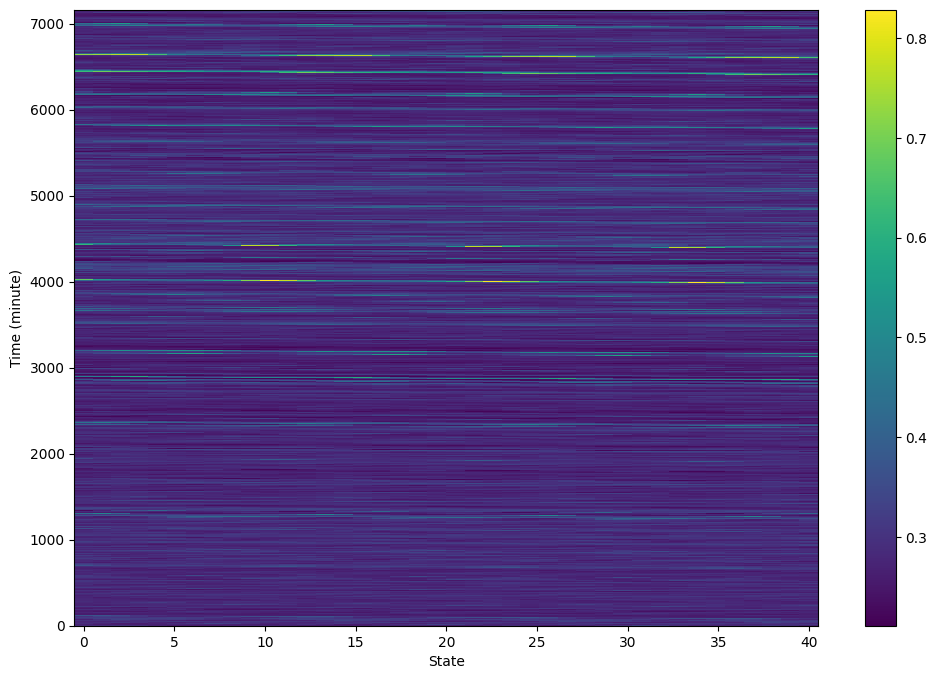

In [4]:
make_plot(D.T, x=x, y=t)

Modifica del metodo DMDc dalla libreria PyDMD

In [5]:
# Metodo DMDc dalla libreria PyDMD

# Modifiche effettuate: 
#1. in def reconstructed_data() aggiunti eigs e self.modes come valori di ritorno => return data, eigs, self.modes

"""
Derived module from dmdbase.py for dmd with control.

Reference:
- Proctor, J.L., Brunton, S.L. and Kutz, J.N., 2016. Dynamic mode decomposition
with control. SIAM Journal on Applied Dynamical Systems, 15(1), pp.142-161.
"""
import numpy as np


class DMDControlOperator(DMDOperator):
    """
    DMD with control base operator. This should be subclassed in order to
    implement the appropriate features.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def __init__(self, svd_rank, svd_rank_omega, tlsq_rank):
        super(DMDControlOperator, self).__init__(
            svd_rank=svd_rank,
            exact=True,
            rescale_mode=None,
            forward_backward=False,
            sorted_eigs=False,
            tikhonov_regularization=None,
        )
        self._svd_rank_omega = svd_rank_omega
        self._tlsq_rank = tlsq_rank


class DMDBKnownOperator(DMDControlOperator):
    """
    DMD with control base operator when B is given.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def compute_operator(self, X, Y, B, controlin):
        """
        Compute the low-rank operator. This is the standard version of the DMD
        operator, with a correction which depends on B.

        :param numpy.ndarray X: matrix containing the snapshots x0,..x{n-1} by
            column.
        :param numpy.ndarray Y: matrix containing the snapshots x1,..x{n} by
            column.
        :param numpy.ndarray B: the matrix B.
        :param numpy.ndarray control: the control input.
        :return: the (truncated) left-singular vectors matrix, the (truncated)
            singular values array, the (truncated) right-singular vectors
            matrix of X.
        :rtype: numpy.ndarray, numpy.ndarray, numpy.ndarray
        """
        X, Y = compute_tlsq(X, Y, self._tlsq_rank)
        Y = Y - B.dot(controlin)
        return super(DMDBKnownOperator, self).compute_operator(X, Y)


class DMDBUnknownOperator(DMDControlOperator):
    """
    DMD with control base operator when B is unknown.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def compute_operator(self, X, Y, controlin):
        """
        Compute the low-rank operator.

        :param numpy.ndarray X: matrix containing the snapshots x0,..x{n-1} by
            column.
        :param numpy.ndarray Y: matrix containing the snapshots x1,..x{n} by
            column.
        :param numpy.ndarray control: the control input.
        :return: the (truncated) left-singular vectors matrix of Y, and
            the product between the left-singular vectors of Y and Btilde.
        :rtype: numpy.ndarray, numpy.ndarray
        """
        snapshots_rows = X.shape[0]

        omega = np.vstack([X, controlin])

        Up, sp, Vp = compute_svd(omega, self._svd_rank_omega)

        Up1 = Up[:snapshots_rows, :]
        Up2 = Up[snapshots_rows:, :]

        Ur, _, _ = compute_svd(Y, self._svd_rank)

        self._Atilde = np.linalg.multi_dot(
            [Ur.T.conj(), Y, Vp, np.diag(np.reciprocal(sp)), Up1.T.conj(), Ur]
        )
        self._compute_eigenquantities()
        self._compute_modes(Y, sp, Vp, Up1, Ur)

        Btilde = np.linalg.multi_dot(
            [Ur.T.conj(), Y, Vp, np.diag(np.reciprocal(sp)), Up2.T.conj()]
        )

        return Ur, Ur.dot(Btilde)

    def _compute_modes(self, Y, sp, Vp, Up1, Ur):
        """
        Private method that computes eigenvalues and eigenvectors of the
        high-dimensional operator (stored in self.modes and self.Lambda).
        """

        self._modes = np.linalg.multi_dot(
            [
                Y,
                Vp,
                np.diag(np.reciprocal(sp)),
                Up1.T.conj(),
                Ur,
                self.eigenvectors,
            ]
        )
        self._Lambda = self.eigenvalues


class DMDc(DMDBase):
    """
    Dynamic Mode Decomposition with control.
    This version does not allow to manipulate the temporal window within the
    system is reconstructed.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    :param opt: argument to control the computation of DMD modes amplitudes.
        See :class:`DMDBase`. Default is False.
    :type opt: bool or int
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    """

    def __init__(self, svd_rank=0, tlsq_rank=0, opt=False, svd_rank_omega=-1):
        # we're going to initialize Atilde when we know if B is known
        self._Atilde = None
        # remember the arguments for when we'll need them
        self._dmd_operator_kwargs = {
            "svd_rank": svd_rank,
            "svd_rank_omega": svd_rank_omega,
            "tlsq_rank": tlsq_rank,
        }

        self._opt = opt
        self._exact = False

        self._B = None
        self._snapshots_holder = None
        self._controlin = None
        self._basis = None

        self._modes_activation_bitmask_proxy = None

    @property
    def svd_rank_omega(self):
        return self.operator._svd_rank_omega

    @property
    def B(self):
        """
        Get the operator B.

        :return: the operator B.
        :rtype: numpy.ndarray
        """
        return self._B

    @property
    def basis(self):
        """
        Get the basis used to reduce the linear operator to the low dimensional
        space.

        :return: the matrix which columns are the basis vectors.
        :rtype: numpy.ndarray
        """
        return self._basis

    def reconstructed_data(self, control_input=None):
        """
        Return the reconstructed data, computed using the `control_input`
        argument. If the `control_input` is not passed, the original input (in
        the `fit` method) is used. The input dimension has to be consistent
        with the dynamics.

        :param numpy.ndarray control_input: the input control matrix.
        :return: the matrix that contains the reconstructed snapshots.
        :rtype: numpy.ndarray
        """
        controlin = (
            np.asarray(control_input)
            if control_input is not None
            else self._controlin
        )

        if controlin.shape[-1] != self.dynamics.shape[-1] - 1:
            raise RuntimeError(
                "The number of control inputs and the number of snapshots to "
                "reconstruct has to be the same"
            )

        eigs = np.power(
            self.eigs, self.dmd_time["dt"] // self.original_time["dt"]
        )
        A = np.linalg.multi_dot(
            [self.modes, np.diag(eigs), np.linalg.pinv(self.modes)]
        )

        data = [self.snapshots[:, 0]]
        expected_shape = data[0].shape

        for i, u in enumerate(controlin.T):
            arr = A.dot(data[i]) + self._B.dot(u)
            if arr.shape != expected_shape:
                raise ValueError(
                    f"Invalid shape: expected {expected_shape}, got {arr.shape}"
                )
            data.append(arr)

        data = np.array(data).T
        return data, eigs, self.modes

    def fit(self, X, I, B=None):
        """
        Compute the Dynamic Modes Decomposition with control given the original
        snapshots and the control input data. The matrix `B` that controls how
        the control input influences the system evolution can be provided by
        the user; otherwise, it is computed by the algorithm.

        :param X: the input snapshots.
        :type X: numpy.ndarray or iterable
        :param I: the control input.
        :type I: numpy.ndarray or iterable
        :param numpy.ndarray B: matrix that controls the control input
            influences the system evolution.
        :type B: numpy.ndarray or iterable
        """
        self._reset()

        self._snapshots_holder = Snapshots(X)
        self._controlin = np.atleast_2d(np.asarray(I))

        n_samples = self.snapshots.shape[1]
        X = self.snapshots[:, :-1]
        Y = self.snapshots[:, 1:]

        self._set_initial_time_dictionary(
            {"t0": 0, "tend": n_samples - 1, "dt": 1}
        )

        if B is None:
            self._Atilde = DMDBUnknownOperator(**self._dmd_operator_kwargs)
            self._basis, self._B = self.operator.compute_operator(
                X, Y, self._controlin
            )
        else:
            self._Atilde = DMDBKnownOperator(**self._dmd_operator_kwargs)
            U, _, _ = self.operator.compute_operator(X, Y, B, self._controlin)

            self._basis = U
            self._B = B

        self._b = self._compute_amplitudes()

        return self

Creazione della funzione Singular Value Hard-Threshold 

In [6]:
def svht(X, sv=None):
    # svht for sigma unknown                                              ## si applica la svht per trovare la matrice sigma
    m,n = sorted(X.shape) # ensures m <= n                                ## sorted(X.shape) ordina la dimensione della matrice                                                                    ## campionata. Si assicura che la dimensione della
                                                                          ## matrice ortogonale di destra sia maggiore della
                                                                          ## dimensione della matrice ortogonale di sinistra.
                
    beta = m / n # ratio between 0 and 1                                  ## beta è il median singular value della matrice X
    
    if sv is None:                                                        ## sv -> singular value
        sv = svdvals(X)
    sv = np.squeeze(sv)                                                   ## np.squeeze() remove axes of length one from a.
    
    omega_approx = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43   ## approssimazione di omega
    
    return np.median(sv) * omega_approx                                   ## np.median(sv) * omega_approx equivale al Tau
                                                                          ## che sarebbe la soglia dell'SVHT

# determine rank-reduction
sv = svdvals(X)
tau = svht(X, sv=sv)
r = sum(sv > tau)

Creazione del metodo DMD.

In [7]:
def dmd(X, Y, truncate=None):
    if truncate == 0:
        # return empty vectors
        mu = np.array([], dtype='complex')
        Phi = np.zeros([X.shape[0], 0], dtype='complex')
    else:
        U2,Sig2,Vh2 = svd(X, False) # SVD of input matrix                 ## U2,Sig2,Vh2 SVD senza troncamento della matrice X
            
        r = len(Sig2) if truncate is None else truncate # rank truncation ## len(Sig2) equivale al numero di elementi di Sig2
        
        U = U2[:,:r]                                                      ## U matrice troncata, da (80,15) a (80,7)
        Sig = diag(Sig2)[:r,:r]                                           ## Sig matrice troncata, da (15,) a (7,7)
        V = Vh2.conj().T[:,:r]                                            ## V matrice troncata, da (15,15) a (15,7)
                                                                          ## conj() è la congiunta
        
        Atil = dot(dot(dot(U.conj().T, Y), V), inv(Sig)) # build A tilde  ## A tilde è la proiezione di A su U,
                                                                          ## dot() è il prodotto scalare tra due array
            
        mu,W = eig(Atil)                                                  ## eig() calcola gli autovalori (mu) e gli autovettori
                                                                          ## destri di una matrice quadrata
            
        Phi = dot(dot(dot(Y, V), inv(Sig)), W) # build DMD modes          ## phi equivale ai modi dinamuci del DMD
                                                                          
    return mu, Phi                                                        ## dmd restituisce mu(autovalori) e phi(modi dinamici)

# "mu" rappresenta gli autovalori del sistema dinamico rappresentato dalla matrice di dati.
# Gli autovalori sono valori numerici che descrivono la stabilità e la dinamica del sistema.

# "phi" rappresenta i modi dinamici o le funzioni proprie del sistema.
# Questi modi dinamici sono funzioni che descrivono il comportamento del sistema in base alla sua dinamica intrinseca.

Creazione del metodo mrDMDc, sostituendo il DMD e la sua ricostruzione con il DMDc modificato.

In [8]:
def mrdmdc(D, U, level=0, bin_num=0, offset=0, max_levels=15, max_cycles=1, do_svht=True):
    """Compute the multi-resolution DMD on the dataset `D`, returning a list of nodes
    in the hierarchy. Each node represents a particular "time bin" (window in time) at
    a particular "level" of the recursion (time scale). The node is an object consisting
    of the various data structures generated by the DMD at its corresponding level and
    time bin. The `level`, `bin_num`, and `offset` parameters are for record keeping 
    during the recursion and should not be modified unless you know what you are doing.
    The `max_levels` parameter controls the maximum number of levels. The `max_cycles`
    parameter controls the maximum number of mode oscillations in any given time scale 
    that qualify as "slow". The `do_svht` parameter indicates whether or not to perform
    optimal singular value hard thresholding."""
     
    
    # 4 times nyquist limit to capture cycles                 ## per il teorema di nyquist, un segnale sinusoidale puo'
                                                              ## essere ricostruito senza perdere informazioni, fintanto che 
                                                              ## viene campionato ad una frequenza due volte o piu' maggiori
                                                              ## della frequenza massima. (valore tipico: 4 volte maggiori)
                
    nyq = 8 * max_cycles                                      ## nyq = 8 * 2

    # time bin size
    bin_size = D.shape[1]                                     ## bin_size equivale al numero di colonne (1600)
    if bin_size < nyq:                                        ## bin_size(1600)<nyq(16)
        return []

    # extract subsamples 
    step = floor(bin_size / nyq) # max step size to capture cycles   ## floor è una funzione che approssima per difetto
                                                                     ## esempio floor(2.9) equivale a 2.
                                                                     ## in questo caso bin_size / nyq == 100 , quindi step=100
            
    _D = D[:,::step]                                           ## D[:,:] è uno slice assignment, in particolare D[:,::step]
                                                               ## considera i valori presi ogni step di tutte le righe e crea
                                                               ## una nuova matrice con solo i valori considerati.
    U = U[:,::step]
    
         
    X = _D[:,:-1]                                              ## in X considera tutti i valori (di _D) escludendo l'ultima 
                                                               ## colonna.
    
    Y = _D[:,1:]                                               ## in Y considera tutti i valori (di _D) escludendo la prima 
                                                               ## colonna.

    # determine rank-reduction
    if do_svht:
        _sv = svdvals(_D)                                      ## svdvals(_D) trova i valori singolari della matrice campionata
                                                               ## _sv è un array con i valori singolari. 
        
        tau = svht(_D, sv=_sv)                                 ## tau -> soglia SVHT
        r = sum(_sv > tau)                                     ## r equivale al n. di valori singolari maggiori della soglia tau
    else:
        r = min(X.shape)                                       ## r -> X.shape = (80, 15) quindi r=min(X.shape) è 15.
    # determine rank-reduction
    if do_svht:
        _sv = svdvals(_D)                                      ## svdvals(_D) trova i valori singolari della matrice campionata
                                                               ## _sv è un array con i valori singolari. 
        
        tau = svht(_D, sv=_sv)                                 ## tau -> soglia SVHT
        r = sum(_sv > tau)                                     ## r equivale al n. di valori singolari maggiori della soglia tau
    else:
        r = min(X.shape)                                       ## r -> X.shape = (80, 15) quindi r=min(X.shape) è 15.
        
    # frequency cutoff (oscillations per timestep)
    rho = max_cycles / bin_size                                ## frequenza di taglio rho definita come n° max di cicli
                                                               ## classificati come "slow" diviso il numero di colonne della
                                                               ## matrice D.  2/1600=0.00125

    # Ricostruzione con DMDc
    dmdc = DMDc(svd_rank=-1)
    D0 = _D[:,:]
    U0 = U[:,1:]
    print(D0.shape)
    print(U0.shape)
    dmdc.fit(D0,U0)
    D, mu, Phi = dmdc.reconstructed_data()
    
    # consolidate slow eigenvalues (as boolean mask)
    slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho       ## ritorna il valore assoluto [abs()] del logaritmo di mu diviso
                                                               ## 2*pi greco*step, che deve essere minore o uguale a rho.
                                                               ## in questo caso [false false false false true true false]
        
    n = sum(slow) # number of slow modes                       ## il numero dei modi "slow" è dato dalla somma di slow.
                                                               ## in questo caso 2.


    if n > 0:                                                  ## se il n° di modi "slow" è maggiore di zero

        # vars for the objective function for D (before subsampling)
        Vand = np.vander(power(mu, 1/step), bin_size, True)   ## vander() restituisce una matrice di Vandermonde, come parameri
                                                              ## vanno passati: un array 1-D (in questo caso mu elevato a potenza
                                                              ## 1/1600), il numero di colonne dell'uscita e un valore booleano
                                                              ## che indica l'incremento (se True allora le colonne saranno
                                                              ## x^0, x^1, x^2... se False saranno x^(N-1), x^(N-2),...)
                        
        P = multiply(dot(Phi.conj().T, Phi), np.conj(dot(Vand, Vand.conj().T)))  ## multiply() serve per moltiplicare due array.
                                                                                 ## in questo caso tra il [prodotto scalare della
                                                                                 ## la congiunta di phi trasposta e phi] e 
                                                                                 ## [la congiunta del prodotto scalare di Vand
                                                                                 ## e la congiunta di Vand trasposta]
        q = np.conj(diag(dot(dot(Vand, D.conj().T), Phi)))    ##

        # find optimal b solution
        b_opt = solve(P, q).squeeze()                         ## b = P^-1 * q
                                                              ## solve() trova le radici di P risolvendo per q

        # time evolution
        Psi = (Vand.T * b_opt).T                              ## Psi matrice (2,1600)

    else:

        # zero time evolution
        b_opt = np.array([], dtype='complex')
        Psi = np.zeros([0, bin_size], dtype='complex')

    # record keeping
    node = type('Node', (object,), {})()
    node.level = level            # level of recursion
    node.bin_num = bin_num        # time bin number
    node.bin_size = bin_size      # time bin size
    node.start = offset           # starting index
    node.stop = offset + bin_size # stopping index
    node.step = step              # step size
    node.rho = rho                # frequency cutoff
    node.r = r                    # rank-reduction
    node.n = n                    # number of extracted modes
    node.mu = mu                  # extracted eigenvalues
    node.Phi = Phi                # extracted DMD modes
    node.Psi = Psi                # extracted time evolution
    node.b_opt = b_opt            # extracted optimal b vector
    nodes = [node]

    # split data into two and do recursion                    ## Qui i dati rimanenti vengono divisi in due e viene applicato
                                                              ## nuovamente il mrdmd su entrambe le metà e così via in modo
                                                              ## ricorsivo...
   
    if level < max_levels:
        split = ceil(bin_size / 2) # where to split           ## ceil(x) approssima per eccesso x
        nodes += mrdmdc(
            D[:,:split],
            U[:,:split],
            level=level+1,
            bin_num=2*bin_num,
            offset=offset,
            max_levels=max_levels,
            max_cycles=max_cycles,
            do_svht=do_svht
            )
        nodes += mrdmdc(
            D[:,split:],
            U[:,split:],
            level=level+1,
            bin_num=2*bin_num+1,
            offset=offset+split,
            max_levels=max_levels,
            max_cycles=max_cycles,
            do_svht=do_svht
            )
    return nodes                                             ## la funzione ritorna una lista di nodi che rappresenta
                                                            ## l'evoluzione dei dati spazio-temporali nel tempo

Esecuzione del metodo mrDMDc.

In [9]:
nodes = mrdmdc(D,U)

(40, 8)
(200, 7)
(40, 8)
(200, 7)


Creazione della funzione stitch che permette l'unione dei vari livelli di ricorsione.

In [10]:
def stitch(nodes, level):

    # get length of time dimension
    start = min([nd.start for nd in nodes])
    stop = max([nd.stop for nd in nodes])
    t = stop - start

    # extract relevant nodes
    nodes = [n for n in nodes if n.level == level]
    nodes = sorted(nodes, key=lambda n: n.bin_num)

    # stack DMD modes
    Phi = np.hstack([n.Phi for n in nodes])

    # allocate zero matrix for time evolution
    nmodes = sum([n.n for n in nodes])
    Psi = np.zeros([nmodes, t], dtype='complex')

    # copy over time evolution for each time bin
    i = 0
    for n in nodes:
        _nmodes = n.Psi.shape[0]
        Psi[i:i+_nmodes,n.start:n.stop] = n.Psi
        i += _nmodes

    return Phi,Psi

Rappresentazione dei modi dinamici e dell'evoluzione nel tempo dei dati.

In [11]:
Phi0,Psi0 = stitch(nodes, 0)
Phi1,Psi1 = stitch(nodes, 1)
#Phi2,Psi2 = stitch(nodes, 2)
#Phi3,Psi3 = stitch(nodes, 3)
#Phi6,Psi6 = stitch(nodes, 6)

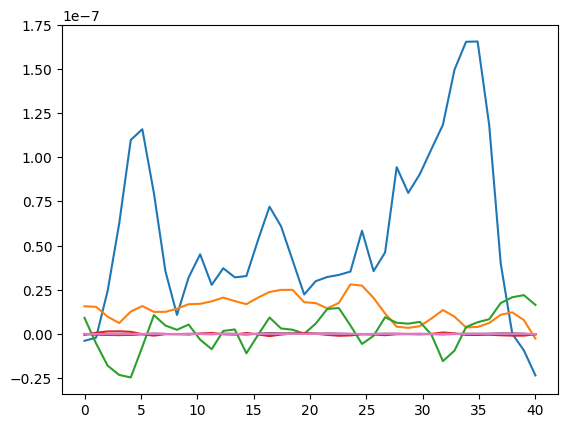

In [12]:
fig = plt.plot(x, Phi0.real)

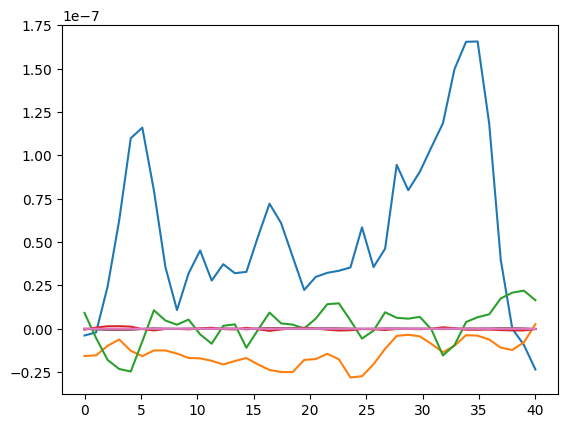

In [13]:
fig = plt.plot(x, Phi1.real)

In [14]:
#fig = plt.plot(x, Phi2.real)

In [15]:
#fig = plt.plot(x, Phi3.real)

In [16]:
#fig = plt.plot(x, Phi6.real)

In [17]:
#fig = plt.plot(t, Psi0.real.T)

In [18]:
#fig = plt.plot(t, Psi1.real.T)

In [19]:
#fig = plt.plot(t, Psi2.real.T)

Inizializzazione del primo livello di ricorsione.

In [20]:
D_mrdmdc = dot(*stitch(nodes, 0))

ValueError: shapes (40,7) and (0,7160) not aligned: 7 (dim 1) != 0 (dim 0)

Creazione della funzione per il calcolo dell'errore quadratico medio (MSE).

In [ ]:
def mse(y_true, y_pred):
    """
    Funzione che calcola MSE.
    :param y_true: lista di numeri che rappresentano i valori reali
    :param y_pred: lista di numeri che rappresentano i valori predetti
    :restituisce: MSE
    """
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true))**2)

Trasformo la matrice del dataset e la matrice della ricostruzione in array ad una dimensione.

In [ ]:
D0 = D[0,:]
D_mrdmdc0 = D_mrdmdc[0,:]

Plotto l'andamento temporale sia del dataset che della ricostruzione e ne calcolo la differenza tra i due.

In [ ]:
plt.figure()
plt.plot(t, D0, 'b', label='Misura')
plt.plot(t, D_mrdmdc0.real, 'g', label='DMD')
plt.legend()
plt.show()

plt.figure()
error=np.array(D0) - np.array(D_mrdmdc0)
plt.plot(t, error.real, 'b', label='Diff')
plt.legend()
plt.show()

Unione dei vari livelli di ricorsione con relativo errore MSE ad ogni iterazione.

In [ ]:
print("Rappresentazione grafica dataset iniziale:")
make_plot(D.T, x=x, y=t)



for i in range(1, 7):
    D_mrdmd += dot(*stitch(nodes, i))
    make_plot(D_mrdmd.T, x=x, y=t, title='levels 0-' + str(i), figsize=(7.5, 5))
    print("Percentuale di errore:")
    print(round(mse(D_mrdmdc.T,D.T),10),"%")

Plotto l'andamento temporale sia del dataset che della ricostruzione e ne calcolo la differenza tra i due.

In [ ]:
plt.figure()
plt.plot(t, D0, 'b', label='Misura')
plt.plot(t, D_mrdmdc0.real, 'g', label='mrDMD')
plt.legend()
plt.show()

plt.figure()
error=np.array(D0) - np.array(D_mrdmdc0)
plt.plot(t, error.real, 'b', label='Diff')
plt.legend()
plt.show()

Calcolo il coefficiente di determinazione (R^2), l'errore percentuale assoluto medio (MAPE) e la radice dell'errore quadratico medio (MSE).

In [ ]:
# Coefficiente di determinazione (R^2), valore tra [0,1]
corr_matrix = np.corrcoef(D0, D_mrdmdc0)
corr = corr_matrix[0,1]
R_sq = corr**2
 
print(np.abs(R_sq))

In [ ]:
# MAPE : Errore Percentuale Assoluto Medio, valore tra [0,1]
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

MAPE = mape(D0,D_mrdmdc0)
print(MAPE)

In [ ]:
# Radice dell'errore quadratico medio
MSE = mean_squared_error(np.abs(D0),np.abs(D_mrdmdc0))
print(math.sqrt(MSE))